In [ ]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [1]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC/ETROC_DAQ')
import run_script
# import parser_arguments
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3
from notebooks.notebook_helpers import *
from fnmatch import fnmatch
import scipy.stats as stats

# Set defaults

In [2]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
chip_names = ["ET2_W36_IP7_12"]
chip_fignames = chip_names
chip_figtitles = chip_names

# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM1"
# I2C addresses for the pixel block and WS
chip_addresses = [0x78]
ws_addresses = [None, None, None]

hostname = "192.168.2.3"

today = datetime.date.today().isoformat()

polarity = "0x000f"

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

# Make i2c_connection class object

In [3]:
# i2c_conn = self, port, chip_addresses, chip_names, chip_fc_delays
i2c_conn = i2c_connection(port,chip_addresses,chip_names,[("1","1")])


# Config chips

### Key is (Disable Pixels, Auto Cal, Chip Peripherals, Basic Peri Reg Check, Pixel Check)

In [7]:
# 0 - 0 - (disable & auto_cal all pixels) - (disable default all pixels) - (auto_TH_CAL) - (set basic peripherals) - (peripheral reg check) -  (pixel ID check)
i2c_conn.config_chips('00100111')
# i2c_conn.config_chips('00001111') # disable and more fun things
# i2c_conn.config_chips('00000100') # set basic peripherals
# i2c_conn.config_chips('00010000') # calibrate only
# i2c_conn.config_chips('00000001') # pixel ID check (I2C check)
# i2c_conn.disable_all_pixels(chip_address=chip_addresses[1])

Passed pixel check for chip: 0x78
Passed peripheral write check for chip: 0x78
Peripherals set for chip: 0x78
Disabled pixels for chip: 0x78


Calibrating row: 100%|██████████| 16/16 [01:31<00:00,  5.71s/it]

Auto calibration finished for chip: 0x78


## Visualize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

In [8]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.show()

<Figure size 1000x1000 with 0 Axes>

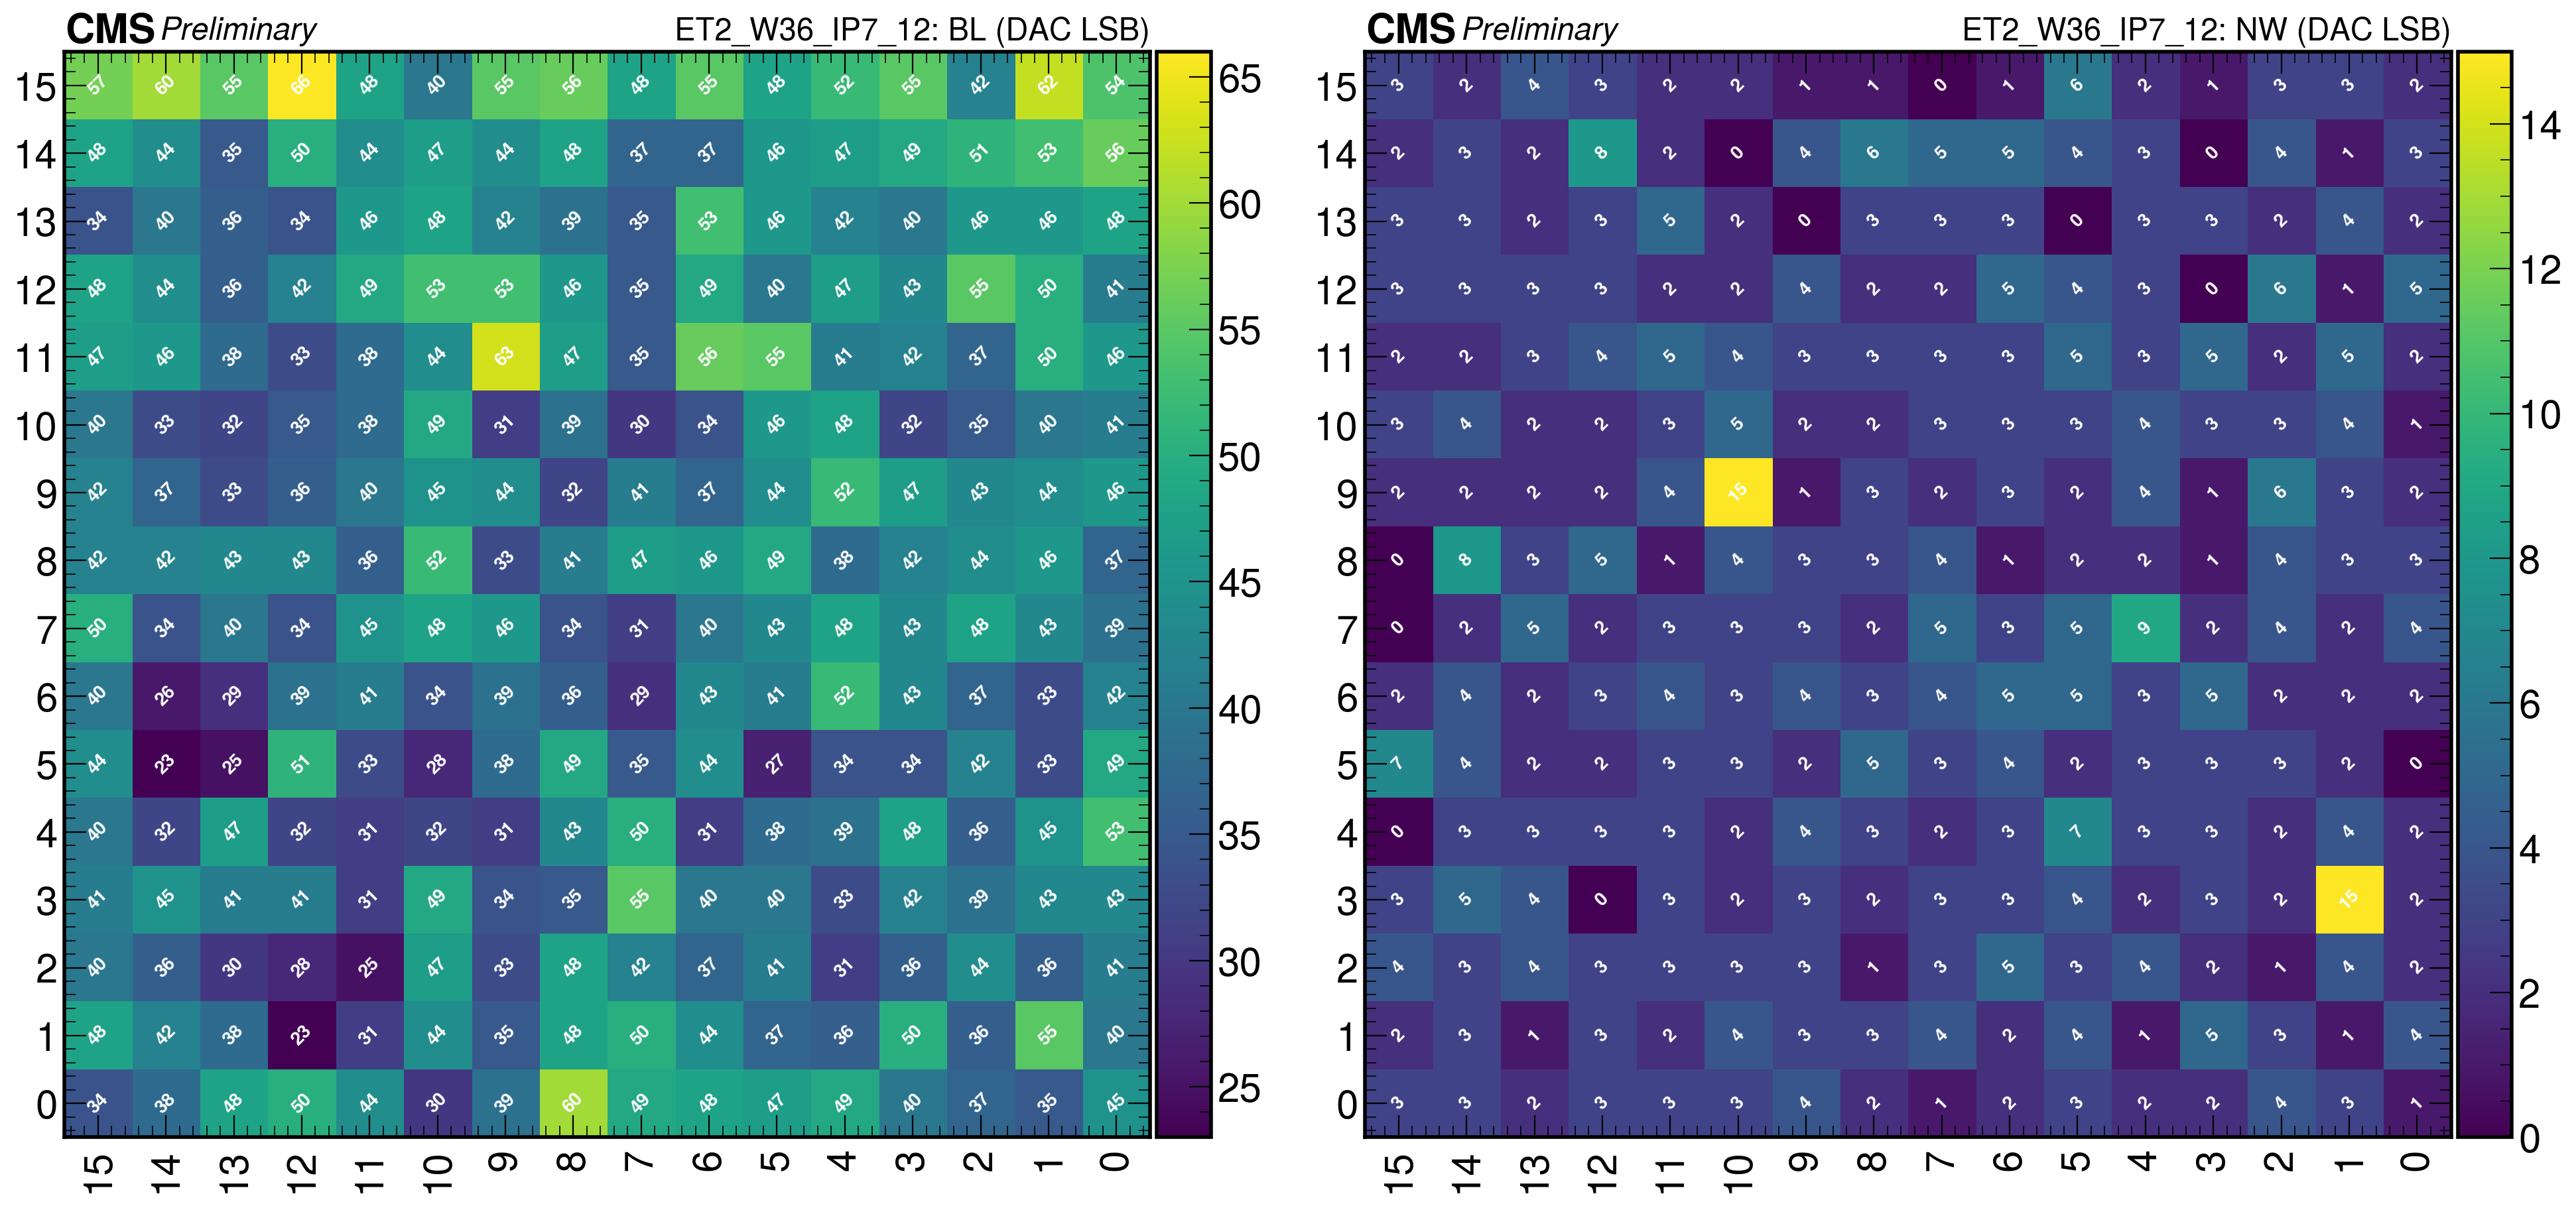

In [9]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
for chip_address, chip_figname, chip_figtitle in zip(chip_addresses,chip_fignames,chip_figtitles):
    BL_map_THCal,NW_map_THCal,BL_df = i2c_conn.get_auto_cal_maps(chip_address)
    fig = plt.figure(dpi=200, figsize=(20,10))
    gs = fig.add_gridspec(1,2)

    ax0 = fig.add_subplot(gs[0,0])
    ax0.set_title(f"{chip_figtitle}: BL (DAC LSB)", size=17, loc="right")
    img0 = ax0.imshow(BL_map_THCal, interpolation='none')
    ax0.set_aspect("equal")
    ax0.invert_xaxis()
    ax0.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax0, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax, orientation="vertical")

    ax1 = fig.add_subplot(gs[0,1])
    ax1.set_title(f"{chip_figtitle}: NW (DAC LSB)", size=17, loc="right")
    img1 = ax1.imshow(NW_map_THCal, interpolation='none')
    ax1.set_aspect("equal")
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax1, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax, orientation="vertical")

    for x in range(16):
        for y in range(16):
            ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
            ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.show()

In [10]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.save_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.save_auto_cal_NW_map(chip_address, chip_name, "")

In [ ]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.load_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.load_auto_cal_NW_map(chip_address, chip_name, "")

# Define pixels of interest

In [11]:
# row_list = [15, 15, 15, 15]
# col_list = [6, 7, 8, 9]
# row_list = [14, 14, 14, 14]
# col_list = [6, 7, 8, 9]
# row_list = [9, 3, 12]
# col_list = [3, 8, 11]
# row_list = [15, 15]
# col_list = [6, 9]
row_list = [14, 14, 15, 15]
col_list = [6, 9, 6, 9]
# row_list = [14, 14, 14, 14, 15, 15, 15, 15]
# col_list = [6, 7, 8, 9, 6, 7, 8, 9]
# row_list = [15]
# col_list = [6]

# col_list, row_list = np.meshgrid(np.arange(16),np.arange(16))
# scan_list = list(zip(row_list.flatten(),col_list.flatten()))

scan_list = list(zip(row_list, col_list))
print(scan_list)

[(14, 6), (14, 9), (15, 6), (15, 9)]


### Enable pixels of Interest

In [12]:
i2c_conn.enable_select_pixels_in_chips(scan_list)

Enabled pixel (14,6) for chip: 0x78
Enabled pixel (14,9) for chip: 0x78
Enabled pixel (15,6) for chip: 0x78
Enabled pixel (15,9) for chip: 0x78


In [13]:
offset = 0x08
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        i2c_conn.pixel_decoded_register_write("QSel", format(0x18, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
        i2c_conn.pixel_decoded_register_write("QInjEn", "1", chip)
    del chip, row_indexer_handle, column_indexer_handle

Operating on chip 0x78 Pixel (14,6)
Operating on chip 0x78 Pixel (14,9)
Operating on chip 0x78 Pixel (15,6)
Operating on chip 0x78 Pixel (15,9)


# Calibrate PLL

In [ ]:
for chip_address in chip_addresses[:]:
    i2c_conn.calibratePLL(chip_address, chip=None)

# Calibrate FC for all I2C

In [ ]:
for chip_address in chip_addresses[:]:
    i2c_conn.asyResetGlobalReadout(chip_address, chip=None)
    i2c_conn.asyAlignFastcommand(chip_address, chip=None)

# Run One Time DAQ to Set FPGA Firmware

In [14]:
os.system("rm -r ../ETROC-Data/2023-10-20_Array_Test_Results/CanBeRemoved_Board0_NoLinkCheck/")
parser = run_script.getOptionParser()
# parser = parser_arguments.create_parser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 15 -o CanBeRemoved_Board0_NoLinkCheck -v -w -s 0x0000 -p 0x000f -d 0x1800 -a 0x0011".split())
IPC_queue = multiprocessing.Queue()
# process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_NoLinkCheck'))
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, None))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj L1A BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

start main process
Verbose Output:  True


-------------------------------------------
--------Set of inputs from the USER--------
Overwrite previously saved files:  True
FPGA IP Address:  192.168.2.3
Number of lines per file created by DAQ script:  50000
Number of lines read per call of fifo readout:  50000
Number of seconds to run this code (>0 means effective):  15
User defined Output Directory:  CanBeRemoved_Board0_NoLinkCheck
Save only the untranslated FPGA binary data (raw output):  False
Save FPGA binary data (raw output) in int format:  False
Save only FPGA translated data frames with DATA:  False
DO NOT save binary data (raw output):  False
--------End of inputs from the USER--------
-------------------------------------------


-------------------------------------------
-------Inputs that have been pre-set-------
ETROC Board Type:  [2, 2, 2, 2]
ETROC Board Size:  [256, 256, 256, 256]
ETROC Board Name:  ['F28', 'F29', 'F30', 'F47']
ETROC Chip ID:  ['10111111100001111', '10111

# Run DAQ with Self-Trigger

### Find the right delay (use the middle of the three success modes, where both Qinj edges are caught)

In [ ]:
for inum in range(475, 495, 1):
    trigger_bit_delay = inum
    print(inum)
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board0_LinkCheck_selfTrigger_delay{inum} -v -w -s 0x0000 -p 0x000f -d {int('000111'+format(inum, '010b'), base=2)} -a 0x0011".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_selfTrigger_delay{inum}'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit QInj BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(10)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser

### Self-triggering mode with QInj

In [ ]:
trigger_bit_delay = int('000111'+format(484, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 30 -o CanBeRemoved_Board0_selfTrigger -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0011".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_selfTrigger'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(20)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Self-trigger mode (source testing)

In [ ]:
trigger_bit_delay = int('000111'+format(484, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 30 -o Source_Testing -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0011".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Source_Testing'))
process.start()

IPC_queue.put('memoFC Start Triggerbit BCR')
while not IPC_queue.empty():
    pass
time.sleep(20)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

# Disconnect I2C Device

In [ ]:
del i2c_conn